# Josh King - Data Wrangling Project (WeRateDogs)


## Table of Contents
<ul>
<li><a href="#gathering">Gathering</a></li><ul>
    <li><a href="#twitter archive">Twitter Archive Data</a></li>
    <li><a href="#image predictions">Image Predictions Data</a></li>
    <li><a href="#api data">API Data</a></li>
    <li><a href="#gathering results">Gathering Results</a></li></ul>
<li><a href="#assessing">Assessing</a></li><ul>
    <li><a href="#visual assessment">Visual Assessing</a></li>
    <li><a href="#programmatic assessment">Programmatic Assessing</a></li>
    <li><a href="#issues to address">Issues to Address</a></li></ul>
<li><a href="#cleaning">Cleaning</a></li><ul>
    <li><a href="#quality cleaning">Quality Cleaning</a></li>
    <li><a href="#tidiness cleaning">Tidiness Cleaning</a></li></ul>
<li><a href="#eda">Exploratory Data Analysis</a></li><ul>
    <li><a href="#top dog stages">Top Dog Stages</a></li>
    <li><a href="#top dog types">Top Dog Types</a></li>
    <li><a href="#top dog names">Top Dog Names</a></li></ul>
<li><a href="#conclusion">Conclusions</a></li>
</ul>

In [637]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import tweepy
import seaborn as sns

sns.set()

%matplotlib inline

<a id='gathering'></a>
# Gathering

<a id='twitter archive'></a>
## Twitter archive dataframe (provided)

In [378]:
# Create a dataframe for the main twitter archive file and check that it worked
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


<a id='image predictions'></a>
## Image predictions dataframe (download programmatically)

In [6]:
# Download the image-predictions.tsv file programmatically into the current directory
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open("image-predictions.tsv", 'wb') as f:
    f.write(response.content)

In [379]:
# Setup a dataframe from the downloaded file and ensure that it worked
df_predictions = pd.read_csv('image-predictions.tsv', sep='\t')
df_predictions.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


<a id='api data'></a>
## Tweet information dataframe (retrieved from Twitter API)

In [4]:
# Setting up the Twitter API
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [5]:
# Testing that my api is working
api.get_user('twitter').followers_count

56191686

In [6]:
# Setting up the tweet id's to look for, but checkking for nulls first
df_archive.tweet_id.isna().sum()

0

In [7]:
tweet_ids = df_archive.tweet_id
# Going to use the length of the series to get an idea of progress through this
list_length = len(tweet_ids)
# Create a dictionary to use for the data from Twitter
twitter_data = {}
twitter_data['tweet_data'] = []
# Create a list to use to put error-throwing tweet id's in
error_ids = []

for tweet_id in tweet_ids:
    try:
        # Get the data from Twitter
        tweet = api.get_status(id=tweet_id, tweet_mode='extended')
        retweet_count = tweet.retweet_count
        like_count = tweet.favorite_count

        # Append the Twitter data to our dictionary
        twitter_data['tweet_data'].append({  
            'id': tweet_id,
            'num_retweets': retweet_count,
            'num_likes': like_count})

        # Getting current index of tweet_id to us as a counter
        current_num = tweet_ids[tweet_ids == tweet_id].index[0]
        # Print the current status of the load. The end= part puts it on the same line
        print("Loaded tweet number " + str(current_num) + " out of " + str(list_length), end='\r')
    except:
        print("Error when downloading " + str(tweet_id))
        error_ids.append(tweet_id)
        
print("All downloading complete.")

Error when downloading 888202515573088257
Error when downloading 873697596434513921
Error when downloading 872668790621863937
Error when downloading 872261713294495745
Error when downloading 869988702071779329
Error when downloading 866816280283807744
Error when downloading 861769973181624320
Error when downloading 856602993587888130
Error when downloading 845459076796616705
Error when downloading 844704788403113984
Error when downloading 842892208864923648
Error when downloading 837012587749474308
Error when downloading 827228250799742977
Error when downloading 812747805718642688
Error when downloading 802247111496568832
Error when downloading 775096608509886464
Error when downloading 770743923962707968


Rate limit reached. Sleeping for: 717


Error when downloading 754011816964026368
Error when downloading 680055455951884288


Rate limit reached. Sleeping for: 711


All downloading complete.out of 2356


We expect that some tweets were deleted before the api-pulldown here and that those deleted tweets represent the errors above.

In [8]:
# Now we want to save the pulled data as a text file to the current directory
# This is good so that all this data isn't just hanging out in the computer memory alone
with open('tweet_json.txt', 'w') as outfile:  
    json.dump(twitter_data, outfile)

In [380]:
# Finally let's read this data into a pandas dataframe

with open('tweet_json.txt') as json_file:
    # Going to make a new dict just in case I go back and re-run things sporadically
    tweet_text_data = json.load(json_file)

# I realized here that there really was no need for that 'tweet_data' level in the previous dict BUT
# it's not worth re-running the whole API pull, so fixing here in the dataframe import
df_apidata = pd.DataFrame(tweet_text_data['tweet_data'], columns=['id', 'num_retweets', 'num_likes'])
df_apidata.head()

,id,num_retweets,num_likes
0,892420643555336193,8172,37492
1,892177421306343426,6050,32242
2,891815181378084864,4001,24286
3,891689557279858688,8325,40829
4,891327558926688256,9019,39043


<a id='gathering results'></a>
## Gathering Results
The resulting dataframes are the following:
* `df_apidata` - The number of retweets and likes from the API pull
* `df_predictions` - The image predictions dataframe downloaded from Udacity
* `df_archive` - The tweet data provided from Udacity as a csv

We also set up a list of tweet id's that, presumably, are deleted as `error_ids`.

<a id='assessing'></a>
# Assessing
All observed issues will be noted above the cleaning section below.

<a id='visual assessment'></a>
## Visual Assesment

### df_apidata

In [22]:
df_apidata.head()

,id,num_retweets,num_likes
0,892420643555336193,8172,37492
1,892177421306343426,6050,32242
2,891815181378084864,4001,24286
3,891689557279858688,8325,40829
4,891327558926688256,9019,39043


In [23]:
df_apidata.tail()

,id,num_retweets,num_likes
2332,666049248165822465,41,104
2333,666044226329800704,135,288
2334,666033412701032449,43,120
2335,666029285002620928,46,124
2336,666020888022790149,493,2500


In [24]:
df_apidata.sample(5)

,id,num_retweets,num_likes
1749,678389028614488064,440,1918
1551,687807801670897665,740,2476
2093,670435821946826752,520,1055
840,763956972077010945,58,781
1424,696754882863349760,372,1532


### df_predictions

In [43]:
df_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [44]:
df_predictions.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [62]:
df_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1084,718540630683709445,https://pbs.twimg.com/media/CfjE5FRXEAErFWR.jpg,2,Maltese_dog,0.632289,True,West_Highland_white_terrier,0.187055,True,cairn,0.044413,True
476,675153376133427200,https://pbs.twimg.com/media/CV6gaUUWEAAnETq.jpg,1,paper_towel,0.327957,False,mailbox,0.096027,False,seat_belt,0.034995,False
1119,726224900189511680,https://pbs.twimg.com/media/ChQRsYaW0AETD7z.jpg,1,standard_poodle,0.261112,True,cocker_spaniel,0.094785,True,bucket,0.069946,False
1915,854365224396361728,https://pbs.twimg.com/media/C9tQokgUIAEETSx.jpg,1,Pembroke,0.907080,True,Cardigan,0.086272,True,Chihuahua,0.001413,True
935,703407252292673536,https://pbs.twimg.com/media/CcMBJODUsAI5-A9.jpg,1,doormat,0.201058,False,turnstile,0.088583,False,carton,0.082924,False


### df_archive

In [46]:
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [47]:
df_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [127]:
# The a's listed above in the name colum looked strange, so let's check that out
df_archive.name.value_counts()

None         745
a             55
Charlie       12
Cooper        11
Lucy          11
Oliver        11
Lola          10
Penny         10
Tucker        10
Winston        9
Bo             9
the            8
Sadie          8
Toby           7
an             7
Daisy          7
Bailey         7
Buddy          7
Stanley        6
Milo           6
Jack           6
Rusty          6
Dave           6
Leo            6
Jax            6
Koda           6
Scout          6
Oscar          6
Bella          6
Chester        5
            ... 
Ambrose        1
Diogi          1
Wesley         1
Maxwell        1
Mosby          1
Tessa          1
Bobb           1
Terrenth       1
Dudley         1
Robin          1
Snoop          1
Fletcher       1
Godi           1
Skittle        1
Champ          1
Schnitzel      1
Brian          1
Trevith        1
Halo           1
Asher          1
Kial           1
Joey           1
Torque         1
Rambo          1
Arya           1
Tycho          1
Stefan         1
Pherb         

In [97]:
df_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1253,710833117892898816,NaN,NaN,2016-03-18 14:19:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Sora. She's an Egyptian Pumpernic...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710833117...,12,10,Sora,None,None,None,None
1841,675878199931371520,NaN,NaN,2015-12-13 03:21:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Ok, I'll admit this is a pretty adorable bunny...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/675878199...,11,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,21955058.0,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
2179,669006782128353280,NaN,NaN,2015-11-24 04:17:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tucker. He is 100% ready for the sport...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669006782...,12,10,Tucker,None,None,None,None
2127,670319130621435904,NaN,NaN,2015-11-27 19:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",AT DAWN...\nWE RIDE\n\n11/10 https://t.co/QnfO...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670319130...,11,10,None,None,None,None,None


In [122]:
print(df_archive.doggo.unique())
print(df_archive.floofer.unique())
print(df_archive.pupper.unique())
print(df_archive.puppo.unique())

['None' 'doggo']
['None' 'floofer']
['None' 'pupper']
['None' 'puppo']


<a id='programmatic assessment'></a>
## Programmatic Assessment

### df_apidata

In [27]:
df_apidata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 3 columns):
id              2337 non-null int64
num_retweets    2337 non-null int64
num_likes       2337 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


In [37]:
df_apidata.id.duplicated().sum()

0

In [39]:
df_apidata.describe()

,id,num_retweets,num_likes
count,2.337000e+03,2337.000000,2337.000000
mean,7.420692e+17,2872.486949,7832.382542
std,6.824243e+16,4851.961889,12142.331051
min,6.660209e+17,1.000000,0.000000
25%,6.783345e+17,578.000000,1357.000000
50%,7.185406e+17,1342.000000,3408.000000
75%,7.986825e+17,3349.000000,9594.000000
max,8.924206e+17,82308.000000,161956.000000


### df_predictions

In [49]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [54]:
df_predictions.tweet_id.duplicated().sum()

0

In [57]:
df_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


### df_archive

In [52]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [94]:
# Getting the data type of the timestamp column
type(df_archive.timestamp[1])

str

In [55]:
df_archive.tweet_id.duplicated().sum()

0

In [58]:
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [107]:
# In the describe function above, we see a 0 minimum for the denominator, so let's investigate
df_archive.sort_values('rating_denominator').head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406...,1,2,an,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
1576,687460506001633280,NaN,NaN,2016-01-14 02:25:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kramer. He's a Picasso Tortellini. Tie...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/687460506...,10,10,Kramer,None,None,None,None
1575,687476254459715584,NaN,NaN,2016-01-14 03:28:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Curtis. He's a fluffball. 11/10 would ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/687476254...,11,10,Curtis,None,None,pupper,None


In [110]:
# Similarly, let's investigate the large max denominator
df_archive.sort_values('rating_denominator').tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1635,684222868335505415,NaN,NaN,2016-01-05 04:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Someone help the girl is being mugged. Several...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684222868...,121,110,None,None,None,None,None
1779,677716515794329600,NaN,NaN,2015-12-18 05:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",IT'S PUPPERGEDDON. Total of 144/120 ...I think...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677716515...,144,120,None,None,None,None,None
1634,684225744407494656,6.842229e+17,4.196984e+09,2016-01-05 04:11:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Two sneaky puppers were not initially seen, mo...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/684225744...,143,130,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None


In [113]:
# There seems to be a number of large denominators, so let's look at it another way
df_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [114]:
# While it's unknown whether a numerator less than 10 is unreasonable,
# It seemed strange for their to be such high numerators, so let's review that
df_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

<a id='issues to address'></a>
## Issues to be addressed
Not that not all of the issues below will necessarily be addressed. The project prompt requests 8 quality and 2 tidiness issues to be cleaned which shall be pulled from the list below. My attempt here though is to focus on the items that might be most relevant for analysis later.

* ***Quality Issues***
    * Since not all tweets are still available (determined through the API pull), and not all tweets have image prediction data, considerations will need be made on dropping certain tweet_ids (potentially down to only the tweets where all data is available). The dataframes should at least be dropped down to only the tweets that still exist.
    * Some tweets are retweets or replies and we are only interested in original tweets (evident from the `df_archive` dataframe).
    * Some tweets are not pictures of dogs and we are only interested in doggies (evident from the `df_predictions` where the predictor suggested items like door mats or paper towels).
    * Timestamp column in `df_archive` is not date-time as it should be.
    * Three tweets in `df_archive` have a rating denominator < 10 (all on WeRateDogs should be 10). These are tweet id's 	835246439529840640, 666287406224695296, and 810984652412424192.
    * There are a number of high value rating denominators in `df_archive` also that don't make sense. These will either need be dropped or repaired somehow.
    * There are a number of unusually high value rating numerators in `df_archive`. While these might be intentional, they will need to be addressed either way.
    * In `df_archive` the source column should just be the url and not include the html tag.
    * In `df_predictions` the predicted values have inconsistent capitalization schemes. The underscores could also be removed to be a more presentable format.
    * In `df_archive` there seem to be a number of erroneous names like "a" or "an".
* ***Tididness Issues***
    * `df_apidata` makes more sense as merged in with `df_archive` since both databases directly provided metrics about individual tweets.
        * When doing so, the merge should occur that "tweet_id" is the column name for the id's to be consistent across all databases.
    * In `df_archive` there are multiple columns for the single variable of dog type, which should be collapsed together.
        * While doing some random sampling of this part of the data visually, you'll notice some rows have multiple dog types/stages, which will need be addressed in the merge.
    * If we are only looking for original tweets, many columns (like "in_reply...." ones) will become irrelevant once we have a clean database.
    * Ultimately, for analysis, it would be nice to have one master dataframe with the most important metrics by tweet id. This will be created as `dfc_analysis` (dataframe) and `twitter_archive_master.csv` (the csv file). The other individual cleaned dataframes can be preserved, but this will be the one to operate our analysis on.

<a id='cleaning'></a>
# Cleaning

## Setting up the cleaned dataframes

In [503]:
dfc_archive = df_archive.copy()
dfc_predictions = df_predictions.copy()
dfc_apidata = df_apidata.copy()

<a id='quality cleaning'></a>
## Quality Cleaning

### Dropping tweet id's
There are a number of tweet id's we want to pull from the dataframes. To make this easier (since we have multiple dataframes), we'll append all such id's to a list `to_drop`.

Here we will only drop non-existent tweets (found via the api data pull), tweets that are replies or retweets, or tweets not about dogs. This may mean that the resultant dataframes might still have different lengths, but we'd like to preseve information as much as possible (rather than dropping down to only tweets appearing in all dataframes). This inconsistency can get addressed by taking this into consideration in analysis.

In [504]:
to_drop = []

* ***Add any tweets from the `error_ids` list to the drop list (these are tweets that no longer exist).***

In [505]:
to_drop.extend(error_ids)

# We're using extend rather than append since appending would add in the new list as an object to the existing

* ***Add any tweets that are replies or retweets from `df_archive` to the drop list.***

In [506]:
# Append the tweet id's that are replies to a user
# If the in_reply_to_user column is not blank, then it is a reply
to_drop.extend(df_archive[df_archive.in_reply_to_user_id.notnull()].tweet_id.tolist())

# We're using extend rather than append since appending would add in the new list as an object to the existing

In [507]:
# Append the tweet id's that are retweets
# If the retweeted_status_id column is not blank, then it is a retweet
to_drop.extend(df_archive[df_archive.retweeted_status_id.notnull()].tweet_id.tolist())

* ***Add any tweet id's that are not about dogs from `df_predictions` to the drop list.***

In [508]:
# The px_dog columns show whether the image prediction yielded a dog or not.
# The columns for p1 is the best prediction, p2 for the second best, and so on.
# While somewhat arbirtary, let's decide that the ones that are not likely tweets about dogs
# are ones where both the first and second predictions do not yield dogs.
# A more rigorous analysis could use the associated p-values, but the noted method is reasonable in this context.
to_drop.extend(df_predictions.query('(p1_dog == False) and (p2_dog == False)').tweet_id.tolist())

In [509]:
# As a justification for the above, we can look at also including ones where p3_dog was true,
# but if we run this and ask for the maximum confidence values, we can see it's pretty low.
df_predictions.query('(p1_dog == False) and (p2_dog == False) and (p3_dog == True)').p3_conf.max()

0.233162

* ***Finally, drop all tweets by the tweet_id column that are not original and not about dogs using the to_drop list.***

In [510]:
dfc_predictions = df_predictions.query('tweet_id not in @to_drop')
dfc_archive = df_archive.query('tweet_id not in @to_drop')
dfc_apidata = df_apidata.query('id not in @to_drop')

# The @ symbol here is used to force the query to treat to_drop as the list that it is

In [511]:
# We can double check this using the below. Every print should be empty.
print(dfc_predictions.query('(p1_dog == False) and (p2_dog == False)'))
print(dfc_archive[dfc_archive.retweeted_status_id.notnull()])
print(dfc_archive[dfc_archive.in_reply_to_user_id.notnull()])
print(dfc_apidata.query('id in @to_drop'))

Empty DataFrame
Columns: [tweet_id, jpg_url, img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog]
Index: []
Empty DataFrame
Columns: [tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, source, text, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls, rating_numerator, rating_denominator, name, doggo, floofer, pupper, puppo]
Index: []
Empty DataFrame
Columns: [tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, source, text, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls, rating_numerator, rating_denominator, name, doggo, floofer, pupper, puppo]
Index: []
Empty DataFrame
Columns: [id, num_retweets, num_likes]
Index: []


### Ratings cleaning
There were a number of anomolous ratings both in the numerator and denominator of `df_archive` that should be considered (both high and low values). However, as some of these values may be intentional, it was decided that the cleaning focus should be on the denominator for two primary reasons. First, the denominator is known to be out of 10 for all WeRateDogs ratings, and without this being the case, it would make analysis difficult (the overall rating would not be standardized). Second, so long as the denominator is standardized, any unusually high or low numerators can be dealt with in statistical analysis via removing outliers if needed. In an ideal case, we would consult with the architects of the data to see what kind of edge cases could creep in and adjust accordingly, but that's not availabe here.

* ***Replace any values in the denominator of `df_archive` that are not 10 with 10.***

In [512]:
# First let's just see what the remaining non-10's look like
dfc_archive.rating_denominator.value_counts()

10     1713
50        3
80        2
11        2
150       1
110       1
90        1
70        1
40        1
20        1
7         1
2         1
Name: rating_denominator, dtype: int64

Interestingly, by removing the non-original and non-dog tweets, this took care of the weird denominators, so we're all set with the denominator. Since that was simple, let's take a peek through the ***numerators*** in more detail to see if their are any that we can reasonably clean. Let's just focus on numerators higher than 20 (since that would double the denominator) and less than 10 (since all dogs should have a rating of 10 or higher). But since these entries may be too many to realistically review manually, let's check the length first.

In [513]:
len(dfc_archive.loc[dfc_archive.rating_numerator > 20].text)

14

In [514]:
len(dfc_archive.loc[dfc_archive.rating_numerator < 10].text)

267

Manually reviewing the over 20's is reasonable, but not the under 10's. Since our analysis will likely focus on the highest rated dogs, it may not be practically significant to worry about the less than 10's anyway.

* ***Review the text associated with rating numerators higher than 20 for tweets that should not be included in our ratings (i.e. are not dogs, are multiple dogs, etc.) and drop those from the dataframe.***

In [515]:
# Reviewing the text for ratings higher than 20
dfc_archive.loc[dfc_archive.rating_numerator > 20].text.tolist()

['The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd',
 'Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx',
 "This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",
 "This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq",
 'Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE',
 'This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq',
 "Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1",
 "Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12",
 'From 

In [516]:
# Looking at the other values so I can match info as needed
dfc_archive.loc[dfc_archive.rating_numerator > 20]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,None,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/709198395...,45,50,None,None,None,None,None
1351,704054845121142784,NaN,NaN,2016-02-28 21:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704054845...,60,50,a,None,None,None,None


From reviewing these manually, there are a number of actions that can be taken:
    * The ones about the floofs being released - multiple dogs, to be dropped - 820690176645140481
    * The one about SAM - no rating provided, to be dropped - 810984652412424192
    * The one about Logan - rating is actually 9.75, can be changed - 786709082849828864
    * The one about Sophie - rating is actually 11.27, can be changed - 778027034220126208
    * The one about the front door - multiple dogs, to be dropped - 758467244762497024
    * The one about Bluebert - rating is actually 11/10, can be changed - 716439118184652801
    * The one about 9 puppers - multiple dogs, to be dropped - 713900603437621249
    * The one about a brigade - multiple dogs, to be dropped - 710658690886586372
    * The one with from left to right - multiple dogs, to be dropped - 709198395643068416
    * The one about a flock - multiple dogs, to be dropped - 704054845121142784	
    * The one about a bucket - multiple dogs, to be dropped - 	697463031882764288
    * The one about being mugged - multiple dogs, to be dropped - 684222868335505415
    * The one about a battalion - multiple dogs, to be dropped - 680494726643068929
    * The one about a platoon - multiple dogs, to be dropped - 675853064436391936

In [517]:
# Now let's create a new drop list based on our findings
to_drop_fromnumer = [820690176645140481, 810984652412424192, 758467244762497024, 713900603437621249, 710658690886586372,
                    709198395643068416, 704054845121142784, 697463031882764288, 684222868335505415, 680494726643068929,
                    675853064436391936]

# Now drop those from the clean database version
dfc_predictions = dfc_predictions.query('tweet_id not in @to_drop_fromnumer')
dfc_archive = dfc_archive.query('tweet_id not in @to_drop_fromnumer')
dfc_apidata = dfc_apidata.query('id not in @to_drop_fromnumer')

In [518]:
# Now change the individual ratings that need be changed
# * The one about Logan - rating is actually 9.75, can be changed - 786709082849828864, row 695
dfc_archive.at[695, 'rating_numerator'] = 9.75
# * The one about Sophie - rating is actually 11.27, can be changed - 778027034220126208, row 763
dfc_archive.at[763, 'rating_numerator'] = 11.27
# * The one about Bluebert - rating is actually 11/10, can be changed - 716439118184652801, row 1202
dfc_archive.at[1202, 'rating_numerator'] = 11

In [519]:
# Finally test that there are no higher than 20 numerators (output should be 0)
len(dfc_archive.loc[dfc_archive.rating_numerator > 20].text)

0

### Misc quality cleaning

* ***Convert the timestamp column in `df_archive` to datetime.***

In [520]:
dfc_archive.timestamp = pd.to_datetime(dfc_archive.timestamp);
# Testing the data type
dfc_archive.timestamp[1]

Timestamp('2017-08-01 00:17:27+0000', tz='UTC')

* ***Remove the html tags from the `df_archive` "source" column so that each value is just a link***

In [521]:
# Let's first see what these links look like
df_archive.source[:5]

0    <a href="http://twitter.com/download/iphone" r...
1    <a href="http://twitter.com/download/iphone" r...
2    <a href="http://twitter.com/download/iphone" r...
3    <a href="http://twitter.com/download/iphone" r...
4    <a href="http://twitter.com/download/iphone" r...
Name: source, dtype: object

In [522]:
# The first text split below peels off the first part of the html by
# centering on the 'href = "' part, with the second column (index 1) where the link begins.

# The second text split utilizes the quote at the end of each link.
# The first column (index 0) leaves our link only.

dfc_archive.source = dfc_archive.source.\
    str.split(pat="href=\"", expand=True)[1].\
    str.split(pat="\"", expand=True)[0]

In [523]:
# And testing it worked
dfc_archive.source[:5]

1    http://twitter.com/download/iphone
2    http://twitter.com/download/iphone
3    http://twitter.com/download/iphone
4    http://twitter.com/download/iphone
5    http://twitter.com/download/iphone
Name: source, dtype: object

* ***In `df_predictions` force all prediction names to have a consistent capitalization scheme and replace the underscores with spaces.***

In [524]:
# Making the changes
dfc_predictions.p1 = dfc_predictions.p1.str.replace(pat="_", repl=" ").str.lower()
dfc_predictions.p2 = dfc_predictions.p1.str.replace(pat="_", repl=" ").str.lower()
dfc_predictions.p3 = dfc_predictions.p1.str.replace(pat="_", repl=" ").str.lower()

# Testing it worked
print(dfc_predictions.p1[:5])
print(dfc_predictions.p2[:5])
print(dfc_predictions.p3[:5])

0    welsh springer spaniel
1                   redbone
2           german shepherd
3       rhodesian ridgeback
4        miniature pinscher
Name: p1, dtype: object
0    welsh springer spaniel
1                   redbone
2           german shepherd
3       rhodesian ridgeback
4        miniature pinscher
Name: p2, dtype: object
0    welsh springer spaniel
1                   redbone
2           german shepherd
3       rhodesian ridgeback
4        miniature pinscher
Name: p3, dtype: object


* ***Replace false names (like "a, an, no") in `df_archive` with None such that all "Nones" are real pet names.***

In [525]:
# First let's look at the list of unique names
np.unique(dfc_archive.name.tolist())

array(['Abby', 'Ace', 'Acro', 'Adele', 'Aiden', 'Aja', 'Akumi', 'Albert',
       'Aldrick', 'Alejandro', 'Alexander', 'Alexanderson', 'Alf',
       'Alfie', 'Alfy', 'Alice', 'Amber', 'Ambrose', 'Amy', 'Andru',
       'Andy', 'Angel', 'Anna', 'Antony', 'Apollo', 'Aqua', 'Archie',
       'Arlen', 'Arlo', 'Arnie', 'Arnold', 'Arya', 'Ash', 'Asher',
       'Ashleigh', 'Aspen', 'Astrid', 'Atlas', 'Atticus', 'Aubie',
       'Augie', 'Autumn', 'Ava', 'Axel', 'Bailey', 'Baloo', 'Balto',
       'Banditt', 'Banjo', 'Barclay', 'Barney', 'Baron', 'Barry', 'Bauer',
       'Baxter', 'Bayley', 'BeBe', 'Bear', 'Beau', 'Beckham', 'Beebop',
       'Beemo', 'Bell', 'Bella', 'Belle', 'Ben', 'Benedict', 'Benji',
       'Benny', 'Bentley', 'Berb', 'Berkeley', 'Bernie', 'Bert', 'Betty',
       'Biden', 'Bilbo', 'Billl', 'Billy', 'Binky', 'Birf', 'Bisquick',
       'Blakely', 'Blanket', 'Blitz', 'Bloo', 'Bloop', 'Blu', 'Blue',
       'Bluebert', 'Bo', 'Bob', 'Bobb', 'Bobbay', 'Bobble', 'Bode',
       'Bodie', 

In [526]:
# Now let's make a new list of values in the above that aren't really a name
# This is somewhat arbitrary of course, but for the context here we can make reasonable judgements
not_names = ['a', 'actually', 'all', 'an', 'getting',
       'incredibly', 'infuriating', 'just', 'life', 'light', 'mad', 'my',
       'not', 'officially', 'old', 'one', 'quite', 'space', 'the', 'very']

In [527]:
# Finally let's do the replace and then test it
dfc_archive.name.replace(to_replace=not_names, value='None', inplace=True)

# Testing it, this shouldn't return any cells
dfc_archive.query('name in @not_names')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


<a id='tidiness cleaning'></a>
## Tidiness Cleaning

* ***`dfc_archive` will now have a number of empty columns from the dropping down to original tweets. Those can now be dropped.***

In [528]:
# Look at the dataframe to see which columns are blank
dfc_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1717 entries, 1 to 2355
Data columns (total 17 columns):
tweet_id                      1717 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1717 non-null datetime64[ns, UTC]
source                        1717 non-null object
text                          1717 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1714 non-null object
rating_numerator              1717 non-null int64
rating_denominator            1717 non-null int64
name                          1717 non-null object
doggo                         1717 non-null object
floofer                       1717 non-null object
pupper                        1717 non-null object
puppo                         1717 non-null object
dtypes: datetime64[ns, UTC]

In [529]:
# Drop the columns
dfc_archive.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id',
                         'retweeted_status_user_id', 'retweeted_status_timestamp'], inplace=True)
# Test the drop
dfc_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1717 entries, 1 to 2355
Data columns (total 12 columns):
tweet_id              1717 non-null int64
timestamp             1717 non-null datetime64[ns, UTC]
source                1717 non-null object
text                  1717 non-null object
expanded_urls         1714 non-null object
rating_numerator      1717 non-null int64
rating_denominator    1717 non-null int64
name                  1717 non-null object
doggo                 1717 non-null object
floofer               1717 non-null object
pupper                1717 non-null object
puppo                 1717 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(8)
memory usage: 254.4+ KB


* ***Merge the different dog stages in `dfc_archive` to one column named "dog_stage".***

In [530]:
# Combine the columns into one
dfc_archive['dog_stage'] = (dfc_archive['doggo'] + dfc_archive['floofer'] + dfc_archive['pupper'] + dfc_archive['puppo'])
# Strip out the duplicate 'None' and replace the resultant blanks with "Unknown"
dfc_archive.dog_stage = dfc_archive.dog_stage.str.strip('None').str.replace(r'^\s*$', 'Unknown', regex=True)
# Check to see how that looks
dfc_archive.dog_stage.value_counts()

Unknown              1434
pupper                180
dogg                   62
pupp                   22
floofer                 9
doggoNonepupper         8
doggoNoneNonepupp       1
doggofloofer            1
Name: dog_stage, dtype: int64

In [531]:
# In the above, we can see some unusual combinations. These probably represent multiples dogs.
# Let's replace these stages with 'multiple dogs'
dfc_archive.dog_stage.replace(to_replace=['doggoNonepupper', 'doggoNoneNonepupp', 'doggofloofer'],
                                  value='multiple dogs', inplace=True)

In [532]:
# Finally drop the now uneeded columns and test the dataframe
dfc_archive.drop(columns=['doggo','floofer','pupper','puppo'], inplace=True)
dfc_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1717 entries, 1 to 2355
Data columns (total 9 columns):
tweet_id              1717 non-null int64
timestamp             1717 non-null datetime64[ns, UTC]
source                1717 non-null object
text                  1717 non-null object
expanded_urls         1714 non-null object
rating_numerator      1717 non-null int64
rating_denominator    1717 non-null int64
name                  1717 non-null object
dog_stage             1717 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(5)
memory usage: 214.1+ KB


In [533]:
dfc_archive.dog_stage.value_counts()

Unknown          1434
pupper            180
dogg               62
pupp               22
multiple dogs      10
floofer             9
Name: dog_stage, dtype: int64

* ***Merge the `dfc_apidata` into `dfc_archive` based on the tweet id (make the tweet_id columns consistent in the process).***

In [534]:
# First double checking these are the same length (they should be from previous work)
print(len(dfc_apidata))
print(len(dfc_archive))

1717
1717


In [535]:
# We should rename the `dfc_apidata` id column to be consistent
dfc_apidata.rename(columns={'id':'tweet_id'}, inplace=True)

In [536]:
# Merge the two dataframes into the dfc_archive dataframe
dfc_archive = pd.merge(dfc_archive, dfc_apidata, on='tweet_id')
# Check the result
dfc_archive.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,num_retweets,num_likes
0,892177421306343426,2017-08-01 00:17:27+00:00,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,Unknown,6050,32242


In [538]:
len(dfc_archive)

1717

* ***Merge the relevant values of `dfc_predictions` with `dfc_archive` to create a new `dfc_analysis` and write that to a csv file.***

In [537]:
# First let's see which columns are worth pulling from the image predictions one by looking at it again
dfc_predictions.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh springer spaniel,0.465074,True,welsh springer spaniel,0.156665,True,welsh springer spaniel,0.061428,True


It would be good to know the predicted dog type, so let's pull that and the confidence in. When we chose whether the data was based on a dog or not, we focused on p1 and p2 values only (justification previously noted), so let's just pull those. We already are assuming it is a dog, so we don't need the is dog column. We also have links to the tweets directly, so we don't need the jpg url.

In [623]:
# Merge the noted columns into the new dfc_analysis dataframe.
# We want a left (dfc_archive) joine as image prediction data may not be available for all tweets BUT
# we still have a lot of rich data for analysis in dfc_archive.
dfc_predictions_subset = dfc_predictions[['tweet_id','p1','p1_conf','p2','p2_conf']]
dfc_analysis = pd.merge(dfc_archive, dfc_predictions_subset, on='tweet_id', how='left')

In [624]:
# Check the new dataframe
dfc_analysis.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,num_retweets,num_likes,p1,p1_conf,p2,p2_conf
0,892177421306343426,2017-08-01 00:17:27+00:00,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,Unknown,6050,32242,chihuahua,0.323581,chihuahua,0.090647
1,891815181378084864,2017-07-31 00:18:03+00:00,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,Unknown,4001,24286,chihuahua,0.716012,chihuahua,0.078253
2,891689557279858688,2017-07-30 15:58:51+00:00,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,Unknown,8325,40829,paper towel,0.170278,paper towel,0.168086
3,891327558926688256,2017-07-29 16:00:24+00:00,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,Unknown,9019,39043,basset,0.555712,basset,0.225770
4,891087950875897856,2017-07-29 00:08:17+00:00,http://twitter.com/download/iphone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,Unknown,2996,19622,chesapeake bay retriever,0.425595,chesapeake bay retriever,0.116317


In [542]:
len(dfc_analysis)

1717

In [546]:
dfc_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1717 entries, 0 to 1716
Data columns (total 15 columns):
tweet_id              1717 non-null int64
timestamp             1717 non-null datetime64[ns, UTC]
source                1717 non-null object
text                  1717 non-null object
expanded_urls         1714 non-null object
rating_numerator      1717 non-null int64
rating_denominator    1717 non-null int64
name                  1717 non-null object
dog_stage             1717 non-null object
num_retweets          1717 non-null int64
num_likes             1717 non-null int64
p1                    1591 non-null object
p1_conf               1591 non-null float64
p2                    1591 non-null object
p2_conf               1591 non-null float64
dtypes: datetime64[ns, UTC](1), float64(2), int64(5), object(7)
memory usage: 214.6+ KB


In [543]:
# And finally write the new master to a csv
dfc_analysis.to_csv('twitter_archive_master.csv')

<a id='eda'></a>
# Exploratory Data Analysis

The following targets were chosen for this analysis:
    * Which dog stage had the highest number of likes/retweets/rating?
    * Which dog type (by image prediction) had the highest number of likes/retweets/rating?
    * What were the names of the best rated dogs?

In [625]:
# Setting up some definitions for the above questions for re-use

top_likes_id = dfc_analysis.num_likes.idxmax()
top_likes_score = dfc_analysis.num_likes.max()

top_retweets_id = dfc_analysis.num_retweets.idxmax()
top_retweets_score = dfc_analysis.num_retweets.max()

top_rating_id = dfc_analysis.rating_numerator.idxmax()
top_rating_score = dfc_analysis.rating_numerator.max()

top10by_likes = dfc_analysis.nlargest(10, 'num_likes')
top10by_retweets = dfc_analysis.nlargest(10, 'num_retweets')
top10by_rating = dfc_analysis.nlargest(10, 'rating_numerator')

top50by_likes = dfc_analysis.nlargest(50, 'num_likes')
top50by_retweets = dfc_analysis.nlargest(50, 'num_retweets')
top50by_rating = dfc_analysis.nlargest(50, 'rating_numerator')

In [626]:
# We should check for ties in the top ratings though
# If any of the below are > 1, there is a tie.

print('Likes check: ' + str(len(dfc_analysis.query('num_likes == @top_likes_score'))))
print('Retweets check: ' + str(len(dfc_analysis.query('num_retweets == @top_retweets_score'))))
print('Ratings check: ' + str(len(dfc_analysis.query('rating_numerator == @top_rating_score'))))

Likes check: 1
Retweets check: 1
Ratings check: 26


We'll have to look at the ratings column differently since multiple entries have the same top score.

<a id='top dog stages'></a>
## Dog stage with the highest metrics
We should bear in mind here that most of the dog stages were unknown, so this data is only so meaningful. As such, we'll likely need to look at both the top 50 and top 10 in each metric to get enough known dog types.

In [558]:
# The top dog stage by likes
print('The highest stage by likes was ' + dfc_analysis.iloc[top_likes_id].dog_stage +
     ' with a score of ' + str(top_likes_score) + ' likes.')

The highest stage by likes was dogg with a score of 161956 likes.


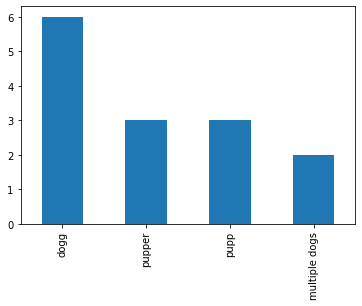

In [577]:
# Top 50 dog stages by likes
top50by_likes.query('dog_stage != "Unknown"').dog_stage.value_counts().plot.bar();

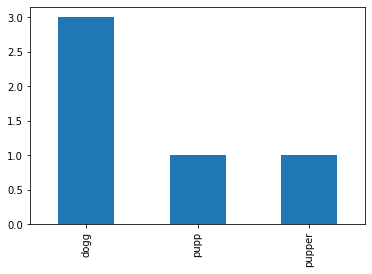

In [580]:
# Top 10 dog stages by likes
top10by_likes.query('dog_stage != "Unknown"').dog_stage.value_counts().plot.bar();

In [556]:
# The top dog stage by retweets
print('The highest stage by retweets was ' + dfc_analysis.iloc[top_retweets_id].dog_stage +
     ' with a score of ' + str(top_retweets_score) + ' retweets.')

The highest stage by retweets was dogg with a score of 82308 retweets.


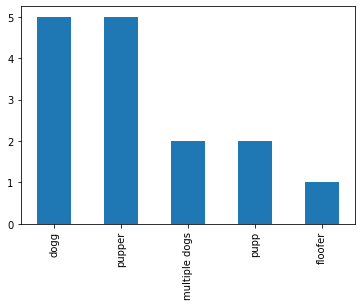

In [578]:
# Top 50 dog stages by retweets
top50by_retweets.query('dog_stage != "Unknown"').dog_stage.value_counts().plot.bar();

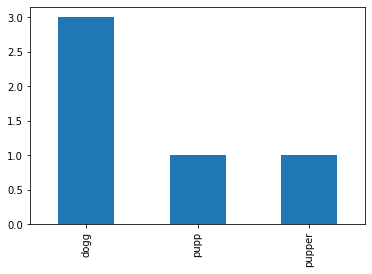

In [581]:
# Top 10 dog stages by retweets
top10by_retweets.query('dog_stage != "Unknown"').dog_stage.value_counts().plot.bar();

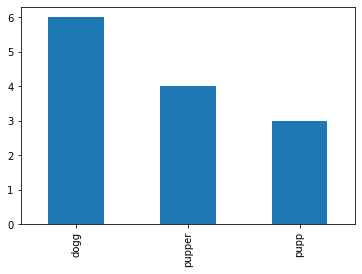

In [582]:
# For rating, the top 14 all tie, so it's better to just look at the top 50.
top50by_rating.query('dog_stage != "Unknown"').dog_stage.value_counts().plot.bar();

<a id='top dog types'></a>
## Dog types with the highest metrics

In [583]:
# The top dog type by likes
print('The highest type by likes was ' + dfc_analysis.iloc[top_likes_id].p1 +
     ' with a score of ' + str(top_likes_score) + ' likes.')

The highest type by likes was labrador retriever with a score of 161956 likes.


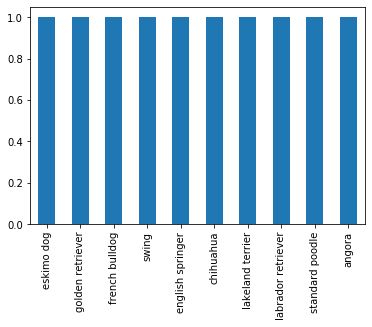

In [585]:
# Top 10 dog types by likes
top10by_likes.p1.value_counts().plot.bar();

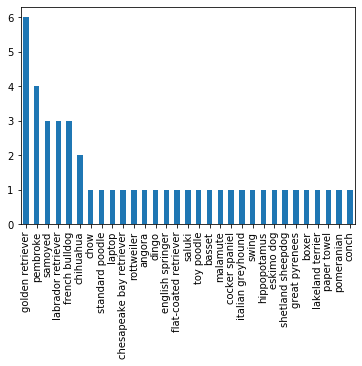

In [587]:
# The top 10 wasn't instructive, so let's look at the top 50
# Top 50 dog types by likes
top50by_likes.p1.value_counts().plot.bar();

In [588]:
# The top dog type by retweets
print('The highest type by retweets was ' + dfc_analysis.iloc[top_retweets_id].p1 +
     ' with a score of ' + str(top_retweets_score) + ' retweets.')

The highest type by retweets was labrador retriever with a score of 82308 retweets.


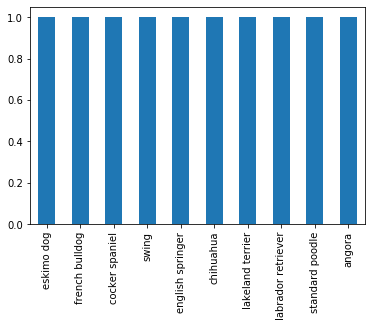

In [589]:
# Top 10 dog types by retweets
top10by_retweets.p1.value_counts().plot.bar();

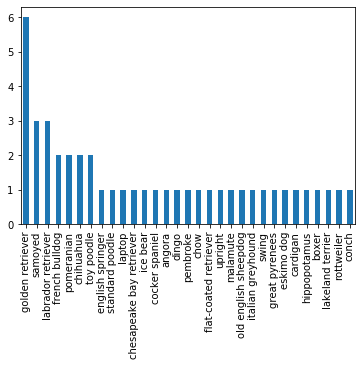

In [590]:
# Again the top 10 wasn't instructive, so let's look at the top 50
# Top 50 dog types by retweets
top50by_retweets.p1.value_counts().plot.bar();

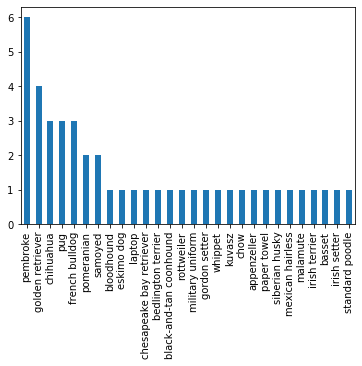

In [591]:
# Top 50 dog types by rating
top50by_rating.p1.value_counts().plot.bar();

<a id='top dog names'></a>
## Dog names with the highest metrics

In [629]:
# The top dog name by likes
print('The highest name by likes was ' + str(dfc_analysis.query('name != "None"').iloc[top_likes_id]['name']) +
     ' with a score of ' + str(top_likes_score) + ' likes.')

The highest name by likes was Kara with a score of 161956 likes.


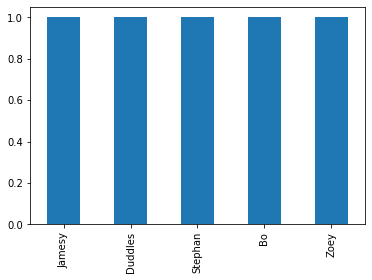

In [605]:
# Top 10 dog names by likes
top10by_likes.query('name != "None"').name.value_counts().plot.bar();

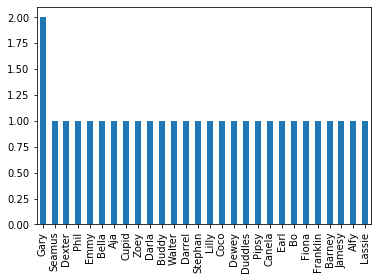

In [630]:
# Top 50 dog names by likes
top50by_likes.query('name != "None"').name.value_counts().plot.bar();

In [647]:
# The top dog name by retweets
print('The highest name by retweets was ' + str(dfc_analysis.query('name != "None"').iloc[top_retweets_id]['name']) +
     ' with a score of ' + str(top_retweets_score) + ' retweets.')

The highest name by retweets was Kara with a score of 82308 retweets.


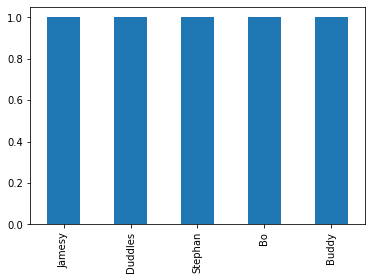

In [609]:
# Top 10 dog names by retweets
top10by_retweets.query('name != "None"').name.value_counts().plot.bar();

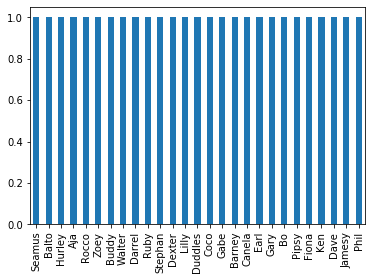

In [610]:
# Top 50 dog names by retweets
top50by_retweets.query('name != "None"').name.value_counts().plot.bar();

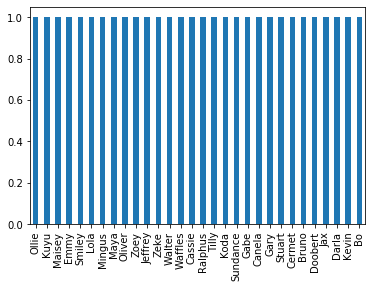

In [613]:
# Top 50 dog names by rating
top50by_rating.query('name != "None"').name.value_counts().plot.bar();

<a id='conclusion'></a>
# Conclusion

After cleaning and reviewing the data, the following insights can be recognized:

* Whether viewed by number of likes or highest rating, the ***highest ranking dog stage*** was always "dogg". This, however, is pulling from a small sample size as most entries did not include the determined dog stage. When viewing by highest number of retweets, however, "dogg" and "pupper" tie as can be seen below (the distribution below being similar to that of the other metrics also):

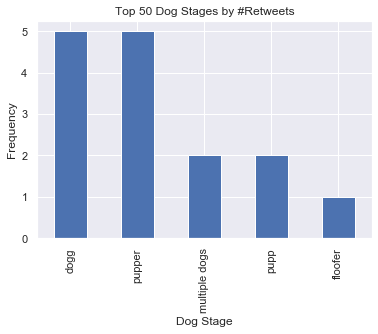

In [641]:
top50by_retweets.query('dog_stage != "Unknown"').dog_stage.value_counts().\
    plot.bar().set(title="Top 50 Dog Stages by #Retweets", xlabel="Dog Stage", ylabel="Frequency");

* When reviewing the ***highest ranked dog type***, you get more diverse results depending on which metric is used:
    * The overall highest by likes and retweets was a labrador retriever (161956 likes and 82308 retweets).
    * However, the most frequent dog types in the top 50 were:
        * By Likes:  golden retriever
        * By Retweets:  golden retriever
        * By Rating:  pembroke

    The top 50 distributions are displayed in the graphs below.

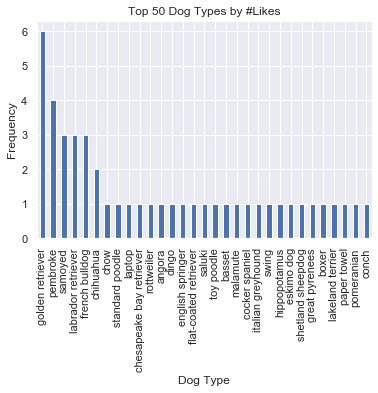

In [645]:
top50by_likes.p1.value_counts().\
    plot.bar().set(title="Top 50 Dog Types by #Likes", xlabel="Dog Type", ylabel="Frequency");

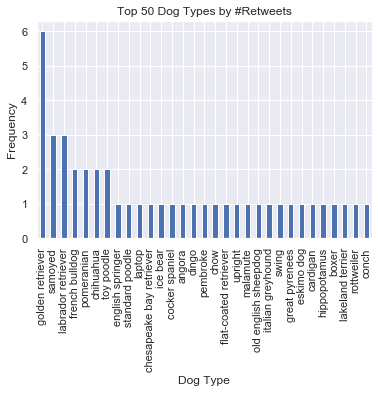

In [644]:
top50by_retweets.p1.value_counts().\
    plot.bar().set(title="Top 50 Dog Types by #Retweets", xlabel="Dog Type", ylabel="Frequency");

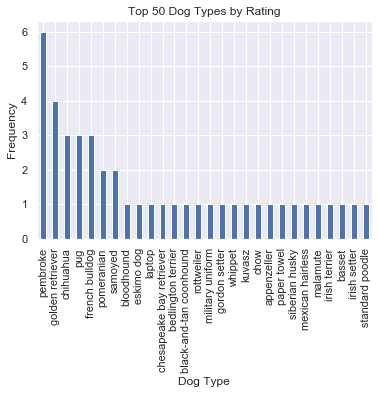

In [643]:
top50by_rating.p1.value_counts().\
    plot.bar().set(title="Top 50 Dog Types by Rating", xlabel="Dog Type", ylabel="Frequency");

* When viewing the ***highest ranking dog names*** we find the interesting result that, whereas the highest ranking overall name by number of likes and retweets was Kara, the no particular name within the top 50 by any metric appeared more frequently than others. The one exception to this was the name "Gary" which did show up one more time (so twice) than the others in number of likes metric, but geneally the distributions were flat and similar to the top 50 ratings distribution shown below:

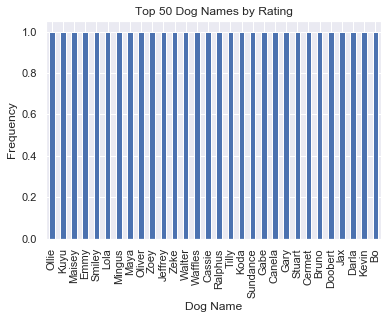

In [648]:
top50by_rating.query('name != "None"').name.value_counts().plot.bar().\
    set(title="Top 50 Dog Names by Rating", xlabel="Dog Name", ylabel="Frequency");

***Overall*** we might argue that dogs of a retriever type and stage "dogg" might be viewed more favorably on Twitter, but given the almost flat spread of the top 50 distributions for names and type, as well as the small sample pool available for  dog stage, it's hard to argue that a particular type or name of dog stands much farther out from the pack without further analysis.